<a href="https://colab.research.google.com/github/Kingbond470/MachineLearning/blob/main/Spam_Sms_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk pandas scikit-learn

In [9]:
import pandas as pd
df = pd.read_csv('spam.csv', encoding='latin-1') # Assuming it's tab-separated for common SMS datasets

In [11]:
print("Dataset Head:")
print(df.head())
print("\nDataset Shape:", df.shape)
print("\nLabel Distribution:")
print(df['v2'].value_counts())

Dataset Head:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Dataset Shape: (5572, 5)

Label Distribution:
v2
Sorry, I'll call later                                                                                                                                                                 30
I cant pick the phone right now. Pls send a message                                                                                                        

In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['v1'] = encoder.fit_transform(df['v1']) # 'ham' will typically be 0, 'spam' will be 1

print("\nLabels after encoding:")
print(df.head())
print("\nLabel Mappings:")
# This shows which original text label maps to 0 and which to 1
print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))


Labels after encoding:
   v1                                                 v2 Unnamed: 2  \
0   0  Go until jurong point, crazy.. Available only ...        NaN   
1   0                      Ok lar... Joking wif u oni...        NaN   
2   1  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   0  U dun say so early hor... U c already then say...        NaN   
4   0  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Label Mappings:
{'ham': np.int64(0), 'spam': np.int64(1)}


In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK data (run this cell once if you haven't)
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer() # For stemming words
stop_words = set(stopwords.words('english')) # Common words to remove

def preprocess_sms(text):
    # 1. Convert to Lowercase: Standardizes casing.
    text = text.lower()

    # 2. Remove URLs: URLs are common in spam but vary greatly.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. Remove Punctuation and Special Characters: Keep only letters, numbers, and spaces.
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # 4. Remove Numbers (Optional): Often, numbers don't add much to spam detection.
    #    Uncomment the line below if you wish to remove numbers.
    #    text = re.sub(r'\d+', '', text)

    # 5. Tokenize: Split the text into individual words.
    words = text.split()

    # 6. Remove Stopwords and Apply Stemming:
    #    Stopwords (like "the", "is") are common and usually don't indicate spam.
    #    Stemming reduces words to their root form (e.g., "running", "runs" -> "run").
    cleaned_words = []
    for word in words:
        if word not in stop_words:
            cleaned_words.append(stemmer.stem(word))

    # 7. Join back into a single string for vectorization.
    return " ".join(cleaned_words)

# Apply the preprocessing function to your 'message' column
df['cleaned_message'] = df['v2'].apply(preprocess_sms)

print("\nMessages after cleaning (first 5 original vs. cleaned):")
print(df[['v2', 'cleaned_message']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Messages after cleaning (first 5 original vs. cleaned):
                                                  v2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4          nah dont think goe usf live around though  


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
# max_features=5000: Limits the vocabulary size to the 5000 most frequent words/bigrams.
#                    This helps manage dimensionality and focus on important terms.
# ngram_range=(1,2): Considers individual words (unigrams) and sequences of two words (bigrams).
#                    Bigrams like "free money" or "click here" are often strong spam indicators.
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit the vectorizer to your cleaned training data and then transform it.
# X will be a sparse matrix of TF-IDF scores.
X = tfidf_vectorizer.fit_transform(df['cleaned_message'])
y = df['v1'] # Our numerical labels

# Check the shape of the feature matrix (number of messages x number of features)
print(f"\nShape of feature matrix (X): {X.shape}")


Shape of feature matrix (X): (5572, 5000)


In [17]:
from sklearn.model_selection import train_test_split

# Split data: 80% for training, 20% for testing
# random_state=42: Ensures reproducibility of your split.
# stratify=y: Crucial for imbalanced datasets (like spam/ham). It ensures that
#             the training and testing sets have roughly the same proportion
#             of 'spam' and 'ham' messages as the original dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\ny_train label distribution (proportion of ham/spam):\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"y_test label distribution (proportion of ham/spam):\n{pd.Series(y_test).value_counts(normalize=True)}")


X_train shape: (4457, 5000)
X_test shape: (1115, 5000)

y_train label distribution (proportion of ham/spam):
v1
0    0.865829
1    0.134171
Name: proportion, dtype: float64
y_test label distribution (proportion of ham/spam):
v1
0    0.866368
1    0.133632
Name: proportion, dtype: float64


In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Choose your model. Multinomial Naive Bayes is a great starting point for text.
# Uncomment other models to experiment.

# Option 1: Multinomial Naive Bayes (Highly recommended for text data)
model = MultinomialNB()

# Option 2: Support Vector Machine (Often achieves high performance, but can be slower for large datasets)
# model = SVC(kernel='linear', random_state=42, probability=True) # probability=True if you need prediction probabilities

# Option 3: Logistic Regression (Simple, interpretable, and effective)
# model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # 'liblinear' is good for small datasets/L1 regularization

# Train the chosen model on the training data
model.fit(X_train, y_train)

print(f"\nModel trained successfully: {type(model).__name__}")


Model trained successfully: MultinomialNB



Accuracy: 0.9731
Precision (Spam): 0.9917
Recall (Spam): 0.8054
F1-Score (Spam): 0.8889

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



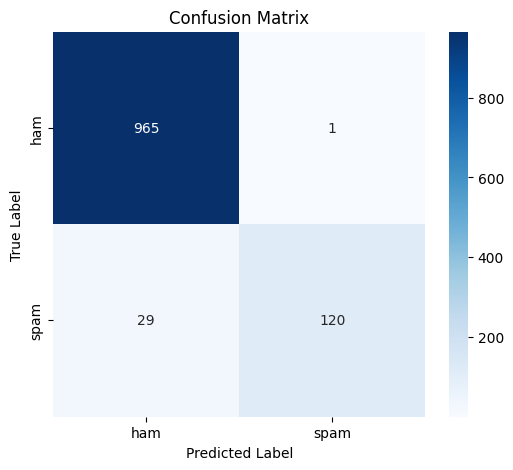

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate key evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
# For precision, recall, f1-score, we specify pos_label=1 assuming 'spam' is encoded as 1.
# This focuses on how well the model identifies spam.
precision = precision_score(y_test, y_pred, pos_label=1) # High precision means fewer false positives (legit SMS marked as spam)
recall = recall_score(y_test, y_pred, pos_label=1)       # High recall means fewer false negatives (spam SMS missed)
f1 = f1_score(y_test, y_pred, pos_label=1)               # Harmonic mean of precision and recall

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision (Spam): {precision:.4f}")
print(f"Recall (Spam): {recall:.4f}")
print(f"F1-Score (Spam): {f1:.4f}")

# Generate and print the full classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['ham', 'spam']))

# Visualize the Confusion Matrix for a clear breakdown of correct/incorrect predictions
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

# Define a dictionary of hyperparameters and their possible values for Multinomial Naive Bayes
# 'alpha' is a smoothing parameter that helps with words not seen in training.
param_grid_mnb = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]}

# For other models, the param_grid would look different:
# For Logistic Regression:
# param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
# For SVM:
# param_grid_svc = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['linear', 'rbf']}

# Initialize GridSearchCV
# estimator: The model you want to tune (e.g., MultinomialNB())
# param_grid: The dictionary of parameters to try
# cv=5: Performs 5-fold cross-validation during tuning for more robust evaluation.
# scoring='f1': Optimizes for F1-score, which is good for imbalanced datasets.
# n_jobs=-1: Uses all available CPU cores for faster computation.
grid_search = GridSearchCV(MultinomialNB(), param_grid_mnb, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to your training data
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best F1-score on training data (cross-validation): {grid_search.best_score_:.4f}")

# Get the best performing model from the grid search
best_model = grid_search.best_estimator_

# Evaluate this best model on the unseen test set
y_pred_best = best_model.predict(X_test)
print("\nEvaluation with Best Model on Test Set:")
print(classification_report(y_test, y_pred_best, target_names=['ham', 'spam']))


Best parameters found: {'alpha': 0.1}
Best F1-score on training data (cross-validation): 0.9387

Evaluation with Best Model on Test Set:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.87      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
import joblib
from google.colab import drive

# Mount Google Drive (if it's not already mounted)
# This will prompt you to authorize Google Drive access.
if not drive.is_mounted('/content/drive'):
    drive.mounted('/content/drive')